# PawsitivePlants 

## PASO 0: EXTRAER Y VERIFICAR DATASET

In [1]:
import os
import zipfile
import shutil
from pathlib import Path

# CONFIGURACIÓN DE RUTA
input_path = "/kaggle/input/house-plant-species"
output_path = "/kaggle/working/house_plant_species"

print("\n📦 VERIFICANDO Y EXTRAYENDO DATASET...")

# Crear carpeta de salida si no existe
os.makedirs(output_path, exist_ok=True)

# Buscar y extraer archivo ZIP (si existe)
zip_found = False
for file in os.listdir(input_path):
    if file.lower().endswith(".zip"):
        zip_path = os.path.join(input_path, file)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_path)
        print(f"✅ Extraído: {file} a {output_path}")
        zip_found = True
        break

if not zip_found:
    print("❌ No se encontró archivo .zip en el dataset proporcionado. Asumiendo que ya está descomprimido.")
    # Si ya está descomprimido, usar input_path como output_path
    if not any(os.path.isdir(os.path.join(input_path, d)) for d in os.listdir(input_path)):
        print("⚠️  No se encontraron carpetas válidas en el dataset proporcionado.")
    else:
        print("✅ Dataset parece estar ya listo para su uso.")
        output_path = input_path

# Mostrar estructura del dataset extraído (hasta 3 archivos por carpeta)
print("\n📂 ESTRUCTURA DE CARPETAS EXTRAÍDAS:")
for root, dirs, files in os.walk(output_path):
    nivel = root.replace(output_path, "").count(os.sep)
    indent = " " * 4 * nivel
    print(f"{indent}📁 {os.path.basename(root)} ({len(files)} archivos)")
    subindent = " " * 4 * (nivel + 1)
    for f in files[:3]:
        print(f"{subindent}📄 {f}")


📦 VERIFICANDO Y EXTRAYENDO DATASET...
❌ No se encontró archivo .zip en el dataset proporcionado. Asumiendo que ya está descomprimido.
✅ Dataset parece estar ya listo para su uso.

📂 ESTRUCTURA DE CARPETAS EXTRAÍDAS:
📁 house-plant-species (0 archivos)
    📁 house_plant_species (0 archivos)
        📁 Orchid (234 archivos)
            📄 208.jpg
            📄 45.jpg
            📄 89.jpg
        📁 Chrysanthemum (209 archivos)
            📄 208.jpg
            📄 45.jpg
            📄 56.jpg
        📁 Venus Flytrap (199 archivos)
            📄 173.png
            📄 45.jpg
            📄 56.jpg
        📁 Poinsettia (Euphorbia pulcherrima) (306 archivos)
            📄 208.jpg
            📄 89.jpg
            📄 20.jpg
        📁 Aloe Vera (252 archivos)
            📄 208.jpg
            📄 45.jpg
            📄 56.jpg
        📁 Areca Palm (Dypsis lutescens) (189 archivos)
            📄 45.jpg
            📄 56.jpg
            📄 89.jpg
        📁 Snake plant (Sanseviera) (396 archivos)
            📄 22

## PASO 1: IMPORTACIÓN DE LIBRERÍAS

In [2]:
print("\n🔧 PASO 1: Importando librerías necesarias...")
print("=" * 60)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms
from PIL import Image
import timm

from tqdm import tqdm
import time

plt.style.use("seaborn-v0_8")

print("✅ Librerías importadas correctamente!")


🔧 PASO 1: Importando librerías necesarias...
✅ Librerías importadas correctamente!


## PASO 2: CONFIGURACIÓN DEL ENTORNO

In [3]:
print("\n🖥️  PASO 2: Configurando entorno de trabajo...")
print("=" * 60)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📱 Dispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"🎮 GPU disponible: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️  Usando CPU - El entrenamiento será más lento")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"🎲 Semilla aleatoria establecida: {SEED}")


🖥️  PASO 2: Configurando entorno de trabajo...
📱 Dispositivo seleccionado: cuda
🎮 GPU disponible: Tesla T4
💾 Memoria GPU: 14.7 GB
🎲 Semilla aleatoria establecida: 42


## PASO 3: DEFINICIÓN DE PLANTAS TÓXICAS Y SEGURAS

In [4]:
print("\n🏷️  PASO 3: Definiendo clasificación de toxicidad...")
print("=" * 60)

TOXIC_PLANTS = {
    # PLANTAS TÓXICAS (Clase 1)
    "Aloe Vera": 1,
    "Azalea": 1,
    "Begonia": 1,
    "Caladium": 1,
    "Chrysanthemum": 1,
    "Cyclamen": 1,
    "Daffodil": 1,
    "Dieffenbachia": 1,
    "English Ivy": 1,
    "Ficus": 1,
    "Geranium": 1,
    "Hibiscus": 1,
    "Hyacinth": 1,
    "Jade Plant": 1,
    "Kalanchoe": 1,
    "Lily": 1,
    "Monstera": 1,
    "Oleander": 1,
    "Philodendron": 1,
    "Poinsettia": 1,
    "Pothos": 1,
    "Rhododendron": 1,
    "Sago Palm": 1,
    "Tulip": 1,
    "ZZ Plant": 1,
    # PLANTAS SEGURAS (Clase 0)
    "African Violet": 0,
    "Areca Palm": 0,
    "Bamboo": 0,
    "Boston Fern": 0,
    "Bromeliad": 0,
    "Cactus": 0,
    "Calathea": 0,
    "Fern": 0,
    "Haworthia": 0,
    "Hoya": 0,
    "Maranta": 0,
    "Orchid": 0,
    "Parlor Palm": 0,
    "Peperomia": 0,
    "Prayer Plant": 0,
    "Rubber Plant": 0,
    "Sansevieria": 0,
    "Spider Plant": 0,
    "Succulent": 0,
    "Wandering Jew": 0,
    "Yucca": 0,
    "Zebra Plant": 0,
}

print(f"📊 Total de especies clasificadas: {len(TOXIC_PLANTS)}")
print(f"🔴 Plantas tóxicas: {sum(TOXIC_PLANTS.values())}")
print(f"🟢 Plantas seguras: {len(TOXIC_PLANTS) - sum(TOXIC_PLANTS.values())}")


🏷️  PASO 3: Definiendo clasificación de toxicidad...
📊 Total de especies clasificadas: 47
🔴 Plantas tóxicas: 25
🟢 Plantas seguras: 22


## PASO 4: CREACIÓN DEL DATASET PERSONALIZADO

In [5]:
print("\n📁 PASO 4: Creando dataset personalizado...")
print("=" * 60)

class PlantDataset(Dataset):
    """
    Dataset personalizado para imágenes de plantas
    
    Cada carpeta con el nombre de la especie debe corresponder a una clave en TOXIC_PLANTS.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
        print(f"  📸 Dataset creado con {len(self.image_paths)} imágenes")
        print(f"  🏷️  Distribución de etiquetas: {Counter(self.labels)}")
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            # En caso de error al cargar, retornar imagen en blanco para evitar crash
            print(f"⚠️  Error cargando {self.image_paths[idx]}: {e}")
            image = Image.new("RGB", (224, 224), color="white")
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]

print("✅ Clase PlantDataset definida correctamente!")


📁 PASO 4: Creando dataset personalizado...
✅ Clase PlantDataset definida correctamente!


## PASO 5: FUNCIÓN DE PREPARACIÓN DE DATOS

In [6]:
print("\n🔍 PASO 5: Definiendo función de preparación de datos...")
print("=" * 60)

def prepare_data(data_dir):
    """
    Escanea carpetas en data_dir, construye DataFrame con rutas de imágenes y etiqueta.
    Solo conserva carpetas cuyo nombre esté en TOXIC_PLANTS.
    """
    image_paths = []
    species_list = []
    labels = []
    
    for root, dirs, files in os.walk(data_dir):
        folder_name = os.path.basename(root)
        if folder_name in TOXIC_PLANTS:
            for fname in files:
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    full_path = os.path.join(root, fname)
                    image_paths.append(full_path)
                    species_list.append(folder_name)
                    labels.append(TOXIC_PLANTS[folder_name])
    
    total_images = len(image_paths)
    print(f"📊 Total de imágenes encontradas en carpetas válidas: {total_images}")
    
    if total_images == 0:
        print("❌ No se encontraron imágenes válidas. Verifica la ruta o los nombres de carpeta.")
        return pd.DataFrame(columns=["image_path", "species", "is_toxic"])
    
    df = pd.DataFrame({
        "image_path": image_paths,
        "species": species_list,
        "is_toxic": labels
    })
    
    df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    counts = df["is_toxic"].value_counts().to_dict()
    safe = counts.get(0, 0)
    toxic = counts.get(1, 0)
    print(f"   ▶️ Ejemplos por etiqueta: {counts}")
    print(f"    Plantas seguras (0): {safe} ({safe/total_images*100:.1f}%)")
    print(f"    Plantas tóxicas (1): {toxic} ({toxic/total_images*100:.1f}%)")
    
    print("\n  🏆 Top 10 especies con más imágenes:")
    species_counts = df["species"].value_counts().head(10)
    for specie, count in species_counts.items():
        icon = "🔴" if TOXIC_PLANTS[specie] == 1 else "🟢"
        print(f"    {icon} {specie}: {count} imágenes")
    
    return df

def analyze_dataset(df):
    """
    Imprime estadísticas básicas del DataFrame preparado.
    """
    print("\n📈 ANÁLISIS DEL DATASET:")
    print(f"  Total de imágenes: {len(df)}")
    if len(df) == 0:
        print("❌ No se encontraron imágenes válidas.")
        return df
    
    print(f"  Especies únicas: {df['species'].nunique()}")
    
    toxicity_counts = df["is_toxic"].value_counts()
    safe = toxicity_counts.get(0, 0)
    toxic = toxicity_counts.get(1, 0)
    total = len(df)
    print(f"\n  🔢 Distribución de toxicidad:")
    print(f"    Plantas seguras (0): {safe} ({safe/total*100:.1f}%)")
    print(f"    Plantas tóxicas (1): {toxic} ({toxic/total*100:.1f}%)")
    
    print("\n  🏆 Top 10 especies con más imágenes:")
    species_counts = df["species"].value_counts().head(10)
    for species, count in species_counts.items():
        icon = "🔴" if TOXIC_PLANTS[species] == 1 else "🟢"
        print(f"    {icon} {species}: {count} imágenes")
    
    return df

print("✅ Funciones de preparación de datos definidas!")


🔍 PASO 5: Definiendo función de preparación de datos...
✅ Funciones de preparación de datos definidas!


## PASO 6: TRANSFORMACIONES DE DATOS

In [7]:
print("\n🔄 PASO 6: Definiendo transformaciones de datos...")
print("=" * 60)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
        hue=0.05
    ),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Transformaciones definidas:")
print("  🔄 Training: Augmentation + Normalización")
print("  🔍 Validation: Solo normalización")


🔄 PASO 6: Definiendo transformaciones de datos...
✅ Transformaciones definidas:
  🔄 Training: Augmentation + Normalización
  🔍 Validation: Solo normalización


## PASO 7: ARQUITECTURA DEL MODELO ViT

In [8]:
print("\n🏗️  PASO 7: Definiendo arquitectura del modelo...")
print("=" * 60)

class ToxicPlantViT(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", num_classes=2, pretrained=True):
        super(ToxicPlantViT, self).__init__()
        print(f"  🔧 Construyendo modelo: {model_name}")
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool="avg"
        )
        self.feature_dim = self.backbone.num_features
        print(f"  📐 Dimensión de features: {self.feature_dim}")
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        print(f"  🎯 Clases de salida: {num_classes}")
        print(f"  📊 Parámetros totales: {sum(p.numel() for p in self.parameters()):,}")
        print(f"  🔒 Parámetros entrenables: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

print("✅ Arquitectura del modelo definida!")


🏗️  PASO 7: Definiendo arquitectura del modelo...
✅ Arquitectura del modelo definida!


## PASO 8: FUNCIONES DE ENTRENAMIENTO Y VALIDACIÓN

In [9]:
print("\n🏃‍♂️ PASO 8: Definiendo funciones de entrenamiento...")
print("=" * 60)

def train_epoch(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(dataloader, desc=f"Época {epoch} - Entrenando")
    for data, target in pbar:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Acc": f"{100. * correct / total:.2f}%"
        })
    return total_loss / len(dataloader), correct / total

def validate_epoch(model, dataloader, criterion, device, epoch):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    all_probs = []
    pbar = tqdm(dataloader, desc=f"Época {epoch} - Validando")
    with torch.no_grad():
        for data, target in pbar:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            probs = torch.softmax(output, dim=1)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            pbar.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "Acc": f"{100. * correct / total:.2f}%"
            })
    return (total_loss / len(dataloader),
            correct / total,
            all_preds,
            all_targets,
            all_probs)

print("✅ Funciones de entrenamiento definidas!")


🏃‍♂️ PASO 8: Definiendo funciones de entrenamiento...
✅ Funciones de entrenamiento definidas!


## PASO 9: MÉTRICAS DE EVALUACIÓN COMPLETAS

In [10]:
print("\n📊 PASO 9: Definiendo métricas de evaluación...")
print("=" * 60)

def calculate_metrics(y_true, y_pred, y_probs):
    accuracy = np.mean(y_true == y_pred)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    try:
        if len(np.unique(y_true)) > 1:
            roc_auc = roc_auc_score(y_true, y_probs[:, 1])
            pr_auc = average_precision_score(y_true, y_probs[:, 1])
        else:
            roc_auc = 0.0
            pr_auc = 0.0
    except:
        roc_auc = 0.0
        pr_auc = 0.0
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision_per_class": precision_score(y_true, y_pred, average=None, zero_division=0),
        "recall_per_class": recall_score(y_true, y_pred, average=None, zero_division=0),
        "f1_per_class": f1_score(y_true, y_pred, average=None, zero_division=0),
    }
    return metrics

def print_metrics(metrics, class_names=["Segura", "Tóxica"]):
    print("\n📈 MÉTRICAS DE EVALUACIÓN:")
    print("=" * 50)
    print(f"🎯 Accuracy:     {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"🎯 Precision:    {metrics['precision']:.4f}")
    print(f"🎯 Recall:       {metrics['recall']:.4f}")
    print(f"🎯 F1-Score:     {metrics['f1_score']:.4f}")
    print(f"🎯 ROC-AUC:      {metrics['roc_auc']:.4f}")
    print(f"🎯 PR-AUC:       {metrics['pr_auc']:.4f}")
    print("\n📊 MÉTRICAS POR CLASE:")
    for i, name in enumerate(class_names):
        if i < len(metrics["precision_per_class"]):
            print(f"  {name}:")
            print(f"    Precision: {metrics['precision_per_class'][i]:.4f}")
            print(f"    Recall:    {metrics['recall_per_class'][i]:.4f}")
            print(f"    F1-Score:  {metrics['f1_per_class'][i]:.4f}")

def plot_training_history(train_losses, val_losses, train_accs, val_accs, metrics_history):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # Pérdida
    axes[0, 0].plot(train_losses, label="Training Loss", marker="o", linewidth=2)
    axes[0, 0].plot(val_losses, label="Validation Loss", marker="s", linewidth=2)
    axes[0, 0].set_title("📉 Pérdida durante el entrenamiento", fontsize=14, fontweight="bold")
    axes[0, 0].set_xlabel("Época")
    axes[0, 0].set_ylabel("Pérdida")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    # Accuracy
    axes[0, 1].plot(train_accs, label="Training Accuracy", marker="o", linewidth=2)
    axes[0, 1].plot(val_accs, label="Validation Accuracy", marker="s", linewidth=2)
    axes[0, 1].set_title("📈 Precisión durante el entrenamiento", fontsize=14, fontweight="bold")
    axes[0, 1].set_xlabel("Época")
    axes[0, 1].set_ylabel("Precisión")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    # F1-Score
    if metrics_history and "f1_score" in metrics_history[0]:
        f1_scores = [m["f1_score"] for m in metrics_history]
        axes[0, 2].plot(f1_scores, label="F1-Score", marker="d", linewidth=2, color="green")
        axes[0, 2].set_title("🎯 F1-Score durante el entrenamiento", fontsize=14, fontweight="bold")
        axes[0, 2].set_xlabel("Época")
        axes[0, 2].set_ylabel("F1-Score")
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    # Precision & Recall
    if metrics_history and "precision" in metrics_history[0]:
        precisions = [m["precision"] for m in metrics_history]
        recalls = [m["recall"] for m in metrics_history]
        axes[1, 0].plot(precisions, label="Precision", marker="o", linewidth=2)
        axes[1, 0].plot(recalls, label="Recall", marker="s", linewidth=2)
        axes[1, 0].set_title("🎯 Precision & Recall", fontsize=14, fontweight="bold")
        axes[1, 0].set_xlabel("Época")
        axes[1, 0].set_ylabel("Valor")
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    # ROC-AUC
    if metrics_history and "roc_auc" in metrics_history[0]:
        roc_aucs = [m["roc_auc"] for m in metrics_history]
        axes[1, 1].plot(roc_aucs, label="ROC-AUC", marker="d", linewidth=2, color="purple")
        axes[1, 1].set_title("📊 ROC-AUC Score", fontsize=14, fontweight="bold")
        axes[1, 1].set_xlabel("Época")
        axes[1, 1].set_ylabel("AUC")
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    # Resumen
    axes[1, 2].text(
        0.5, 0.5,
        "📚 Resumen de Entrenamiento\n\n"
        f"🏆 Mejor Accuracy: {max(val_accs):.4f}\n"
        f"📉 Pérdida Final: {val_losses[-1]:.4f}\n"
        f"⏱️ Épocas: {len(train_losses)}\n"
        f"🎯 Convergencia: {'Sí' if val_losses[-1] < val_losses[0] else 'No'}",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[1, 2].transAxes,
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7)
    )
    axes[1, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=["Segura", "Tóxica"]):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    import seaborn as sns
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names,
        ax=ax1, cbar_kws={"label": "Número de muestras"}
    )
    ax1.set_title("🔢 Matriz de Confusión - Valores Absolutos", fontsize=14, fontweight="bold")
    ax1.set_ylabel("Etiqueta Verdadera")
    ax1.set_xlabel("Etiqueta Predicha")

    sns.heatmap(
        cm_percent, annot=True, fmt=".1f", cmap="Oranges",
        xticklabels=class_names, yticklabels=class_names,
        ax=ax2, cbar_kws={"label": "Porcentaje (%)"}
    )
    ax2.set_title("📊 Matriz de Confusión - Porcentajes", fontsize=14, fontweight="bold")
    ax2.set_ylabel("Etiqueta Verdadera")
    ax2.set_xlabel("Etiqueta Predicha")

    plt.tight_layout()
    plt.show()

    print("\n🔍 INTERPRETACIÓN DE LA MATRIZ DE CONFUSIÓN:")
    print("=" * 60)
    tn, fp, fn, tp = cm.ravel()
    print(f"✅ Verdaderos Negativos (TN): {tn} - Plantas seguras correctamente identificadas")
    print(f"❌ Falsos Positivos (FP): {fp} - Plantas seguras marcadas como tóxicas")
    print(f"❌ Falsos Negativos (FN): {fn} - Plantas tóxicas marcadas como seguras")
    print(f"✅ Verdaderos Positivos (TP): {tp} - Plantas tóxicas correctamente identificadas")
    print("\n⚠️  ANÁLISIS DE ERRORES:")
    if fp > fn:
        print("   El modelo tiende a ser CONSERVADOR (marca plantas seguras como tóxicas)")
        print("   Esto es PREFERIBLE para la seguridad de los gatos")
    elif fn > fp:
        print("   El modelo tiende a ser PERMISIVO (marca plantas tóxicas como seguras)")
        print("   Esto es PELIGROSO para la seguridad de los gatos")
    else:
        print("   El modelo tiene errores balanceados")

def plot_roc_curve(y_true, y_probs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fpr, tpr, _ = roc_curve(y_true, y_probs[:, 1])
    roc_auc = roc_auc_score(y_true, y_probs[:, 1])
    ax1.plot(fpr, tpr, linewidth=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    ax1.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random Classifier")
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel("Tasa de Falsos Positivos")
    ax1.set_ylabel("Tasa de Verdaderos Positivos")
    ax1.set_title("📈 Curva ROC", fontsize=14, fontweight="bold")
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    precision, recall, _ = precision_recall_curve(y_true, y_probs[:, 1])
    pr_auc = average_precision_score(y_true, y_probs[:, 1])
    ax2.plot(recall, precision, linewidth=2, label=f"PR Curve (AUC = {pr_auc:.4f})")
    ax2.axhline(y=np.mean(y_true), color="k", linestyle="--", linewidth=1, label="Random Classifier")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.set_title("🎯 Curva Precision-Recall", fontsize=14, fontweight="bold")
    ax2.legend(loc="lower left")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


📊 PASO 9: Definiendo métricas de evaluación...


## PASO 10: FUNCIÓN PRINCIPAL DE ENTRENAMIENTO

In [11]:
print("\n🚀 PASO 10: Definiendo función principal de entrenamiento...")
print("=" * 60)

def train_model(
    data_dir,
    num_epochs=5,
    batch_size=32,
    learning_rate=1e-4
):
    """
    Función principal de entrenamiento del modelo

    Args:
        data_dir (str): Directorio del dataset
        num_epochs (int): Número de épocas
        batch_size (int): Tamaño del batch
        learning_rate (float): Tasa de aprendizaje
    Returns:
        model, metrics_final, val_loader
    """
    print(f"🎯 CONFIGURACIÓN DEL ENTRENAMIENTO:")
    print(f"   📁 Dataset: {data_dir}")
    print(f"   🔄 Épocas: {num_epochs}")
    print(f"   📦 Batch size: {batch_size}")
    print(f"   📈 Learning rate: {learning_rate}")

    # 10.1 PREPARAR DATOS
    print(f"\n📊 PREPARANDO DATOS...")
    df = prepare_data(data_dir)
    df = analyze_dataset(df)
    if df is None or len(df) == 0:
        print("❌ No se encontraron datos válidos!")
        return None, None, None

    # 10.2 DIVIDIR TRAIN/VALIDATION
    print(f"\n🔪 DIVIDIENDO DATASET...")
    train_df, val_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df["is_toxic"],
        random_state=SEED
    )
    print(f"   📚 Training set: {len(train_df)} imágenes")
    print(f"   🔍 Validation set: {len(val_df)} imágenes")

    train_dist = train_df["is_toxic"].value_counts()
    val_dist = val_df["is_toxic"].value_counts()
    print(f"   📊 Distribución training - Seguras: {train_dist.get(0, 0)}, Tóxicas: {train_dist.get(1, 0)}")
    print(f"   📊 Distribución validation - Seguras: {val_dist.get(0, 0)}, Tóxicas: {val_dist.get(1, 0)}")

    # 10.3 CREAR DATASETS Y DATALOADERS (Oversampling)
    print(f"\n🔄 CREANDO DATALOADERS...")
    train_dataset = PlantDataset(
        train_df["image_path"].values,
        train_df["is_toxic"].values,
        transform=train_transform
    )
    val_dataset = PlantDataset(
        val_df["image_path"].values,
        val_df["is_toxic"].values,
        transform=val_transform
    )

    counts = train_df["is_toxic"].value_counts().sort_index().values  # [n_seguras, n_tóxicas]
    weights = 1.0 / torch.tensor(counts, dtype=torch.float32)
    sample_weights = train_df["is_toxic"] \
        .map({0: float(weights[0].item()), 1: float(weights[1].item())}) \
        .to_numpy(dtype=float)
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(train_df),
        replacement=True
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    print(f"   ✅ DataLoaders creados exitosamente!")
    print(f"   📦 Batches de entrenamiento: {len(train_loader)}")
    print(f"   📦 Batches de validación: {len(val_loader)}")

    # 10.4 INICIALIZAR MODELO
    print(f"\n🏗️  INICIALIZANDO MODELO...")
    model = ToxicPlantViT(model_name="vit_base_patch16_224", num_classes=2, pretrained=True)
    model = model.to(device)

    # 10.5 CONFIGURAR OPTIMIZACIÓN (Pesos manuales)
    print(f"\n⚙️  CONFIGURANDO OPTIMIZACIÓN...")
    class_weights_manual = torch.tensor([1.0, 2.0], dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_manual)
    print(f"   ⚖️  Pesos de clases (manual): {class_weights_manual.cpu().numpy()}")

    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01,
        betas=(0.9, 0.99)
    )
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)
    print(f"   📈 Optimizador: AdamW")
    print(f"   📉 Scheduler: StepLR (cada 2 épocas, factor 0.7)")

    # 10.6 LOOP DE ENTRENAMIENTO
    print(f"\n🏃‍♂️ INICIANDO ENTRENAMIENTO...")
    print("=" * 60)

    best_val_acc = 0
    best_val_f1 = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    metrics_history = []
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f"\n🔄 ÉPOCA {epoch+1}/{num_epochs}")
        print("-" * 40)

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch+1)
        val_loss, val_acc, val_preds, val_targets, val_probs = validate_epoch(
            model, val_loader, criterion, device, epoch+1
        )

        metrics = calculate_metrics(val_targets, val_preds, np.array(val_probs))
        metrics_history.append(metrics)

        old_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        new_lr = optimizer.param_groups[0]["lr"]

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        epoch_time = time.time() - epoch_start

        print(f"\n📊 RESULTADOS ÉPOCA {epoch+1}:")
        print(f"   🏃‍♂️ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
        print(f"   🔍 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")
        print(f"   🎯 F1-Score: {metrics['f1_score']:.4f}")
        print(f"   📈 ROC-AUC: {metrics['roc_auc']:.4f}")
        print(f"   📉 Learning Rate: {old_lr:.2e} → {new_lr:.2e}")
        print(f"   ⏱️  Tiempo: {epoch_time:.1f}s")

        if metrics["f1_score"] > best_val_f1:
            best_val_f1 = metrics["f1_score"]
            best_val_acc = val_acc
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_acc": val_acc,
                    "val_f1": metrics["f1_score"],
                    "metrics": metrics,
                },
                "best_toxic_plant_model.pth",
            )
            print(f"   🏆 ¡Nuevo mejor modelo guardado! F1: {best_val_f1:.4f}")

    total_time = time.time() - start_time
    print(f"\n✅ ENTRENAMIENTO COMPLETADO!")
    print(f"   ⏱️  Tiempo total: {total_time/60:.1f} minutos")
    print(f"   🏆 Mejor F1-Score: {best_val_f1:.4f}")
    print(f"   🏆 Mejor Accuracy: {best_val_acc:.4f}")

    # 10.7 EVALUACIÓN FINAL
    print(f"\n🔍 EVALUACIÓN FINAL DEL MODELO...")
    print("=" * 60)

    checkpoint = torch.load("best_toxic_plant_model.pth", weights_only=False)
    model.load_state_dict(checkpoint["model_state_dict"])

    _, _, final_preds, final_targets, final_probs = validate_epoch(
        model, val_loader, nn.CrossEntropyLoss(), device, "Final"
    )
    final_metrics = calculate_metrics(final_targets, final_preds, np.array(final_probs))
    print_metrics(final_metrics)

    print(f"\n📊 GENERANDO VISUALIZACIONES...")
    plot_training_history(train_losses, val_losses, train_accs, val_accs, metrics_history)
    plot_confusion_matrix(final_targets, final_preds)
    if len(np.unique(final_targets)) > 1:
        plot_roc_curve(final_targets, np.array(final_probs))

    return model, final_metrics, val_loader


🚀 PASO 10: Definiendo función principal de entrenamiento...


## PASO 11: FUNCIÓN DE PREDICCIÓN PARA NUEVAS IMÁGENES

In [12]:
print("\n🔮 PASO 11: Definiendo función de predicción...")
print("=" * 60)

def predict_plant_toxicity(model, image_path, transform=val_transform, device=device, umbral_tox=0.7):
    model.eval()
    try:
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            prob_tox = probabilities[0][1].item()
            prediction = 1 if prob_tox >= umbral_tox else 0
            confidence = probabilities[0][prediction].item()
        return {
            "is_toxic": prediction == 1,
            "prediction_class": "Tóxica" if prediction == 1 else "Segura",
            "confidence": confidence,
            "probability_toxic": prob_tox,
            "probability_safe": probabilities[0][0].item(),
            "recommendation": get_safety_recommendation(prob_tox),
        }
    except Exception as e:
        print(f"❌ Error en predicción: {e}")
        return None

def get_safety_recommendation(toxic_prob):
    if toxic_prob > 0.8:
        return "🚨 ALTO RIESGO: Mantener alejada de gatos"
    elif toxic_prob > 0.6:
        return "⚠️  PRECAUCIÓN: Consultar veterinario"
    elif toxic_prob > 0.4:
        return "❓ INCIERTO: Supervisión recomendada"
    else:
        return "✅ PROBABLE SEGURIDAD: Pero siempre supervisar"

def demonstrate_prediction(model, val_loader, num_examples=5, umbral_tox=0.7):
    print(f"\n🔍 DEMOSTRANDO PREDICCIONES EN {num_examples} EJEMPLOS:")
    print("=" * 70)
    model.eval()
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(1, min(num_examples, len(images)), figsize=(15, 3))
    if num_examples == 1:
        axes = [axes]
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        preds_tensor = (probabilities[:, 1] >= umbral_tox).long()
        predictions = preds_tensor
    for i in range(min(num_examples, len(images))):
        img = images[i].cpu()
        img = (
            img
            * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        )
        img = torch.clamp(img, 0, 1)
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(
            f"Real: {'Tóxica' if labels[i] == 1 else 'Segura'}\n"
            + f"Pred: {'Tóxica' if predictions[i] == 1 else 'Segura'}\n"
            + f"Conf: {probabilities[i][predictions[i]]:.2f}",
            fontsize=10,
            color="green" if labels[i] == predictions[i] else "red",
        )
        axes[i].axis("off")
        toxic_prob = probabilities[i][1].item()
        safe_prob = probabilities[i][0].item()
        print(f"🖼️  Ejemplo {i+1}:")
        print(f"   🏷️  Etiqueta real: {'Tóxica' if labels[i] == 1 else 'Segura'}")
        print(f"   🎯 Predicción: {'Tóxica' if predictions[i] == 1 else 'Segura'}")
        print(f"   📊 Prob. Tóxica: {toxic_prob:.3f} ({toxic_prob*100:.1f}%)")
        print(f"   📊 Prob. Segura: {safe_prob:.3f} ({safe_prob*100:.1f}%)")
        print(f"   💡 Recomendación: {get_safety_recommendation(toxic_prob)}")
        print(f"   {'✅' if labels[i] == predictions[i] else '❌'} {'Correcto' if labels[i] == predictions[i] else 'Incorrecto'}")
        print()
    plt.tight_layout()
    plt.show()


🔮 PASO 11: Definiendo función de predicción...


## PASO 12: EJECUCIÓN PRINCIPAL


🌱 CLASIFICADOR DE PLANTAS TÓXICAS PARA GATOS
🎯 Objetivo: Proteger la salud felina mediante IA
🤖 Modelo: Vision Transformer (ViT)
📊 Dataset: House Plant Species
⚡ Optimizado para Kaggle

🔎 Llamando a train_model con ruta: /kaggle/input/house-plant-species
🎯 CONFIGURACIÓN DEL ENTRENAMIENTO:
   📁 Dataset: /kaggle/input/house-plant-species
   🔄 Épocas: 5
   📦 Batch size: 16
   📈 Learning rate: 0.0001

📊 PREPARANDO DATOS...
📊 Total de imágenes encontradas en carpetas válidas: 1549
   ▶️ Ejemplos por etiqueta: {1: 922, 0: 627}
    Plantas seguras (0): 627 (40.5%)
    Plantas tóxicas (1): 922 (59.5%)

  🏆 Top 10 especies con más imágenes:
    🔴 Tulip: 339 imágenes
    🟢 Calathea: 329 imágenes
    🔴 Aloe Vera: 247 imágenes
    🟢 Orchid: 233 imágenes
    🔴 Chrysanthemum: 208 imágenes
    🔴 Kalanchoe: 128 imágenes
    🟢 Yucca: 65 imágenes

📈 ANÁLISIS DEL DATASET:
  Total de imágenes: 1549
  Especies únicas: 7

  🔢 Distribución de toxicidad:
    Plantas seguras (0): 627 (40.5%)
    Plantas tóxic

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

  📐 Dimensión de features: 768
  🎯 Clases de salida: 2
  📊 Parámetros totales: 86,194,434
  🔒 Parámetros entrenables: 86,194,434

⚙️  CONFIGURANDO OPTIMIZACIÓN...
   ⚖️  Pesos de clases (manual): [1. 2.]
   📈 Optimizador: AdamW
   📉 Scheduler: StepLR (cada 2 épocas, factor 0.7)

🏃‍♂️ INICIANDO ENTRENAMIENTO...

🔄 ÉPOCA 1/5
----------------------------------------


Época 1 - Validando: 100%|██████████| 20/20 [00:07<00:00,  2.59it/s, Loss=0.0369, Acc=89.03%]



📊 RESULTADOS ÉPOCA 1:
   🏃‍♂️ Train Loss: 0.3757 | Train Acc: 0.8160 (81.60%)
   🔍 Val Loss: 0.3080 | Val Acc: 0.8903 (89.03%)
   🎯 F1-Score: 0.8914
   📈 ROC-AUC: 0.9822
   📉 Learning Rate: 1.00e-04 → 1.00e-04
   ⏱️  Tiempo: 51.3s
   🏆 ¡Nuevo mejor modelo guardado! F1: 0.8914

🔄 ÉPOCA 2/5
----------------------------------------


Época 2 - Validando: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s, Loss=0.3923, Acc=90.65%]



📊 RESULTADOS ÉPOCA 2:
   🏃‍♂️ Train Loss: 0.1388 | Train Acc: 0.9500 (95.00%)
   🔍 Val Loss: 0.3705 | Val Acc: 0.9065 (90.65%)
   🎯 F1-Score: 0.9073
   📈 ROC-AUC: 0.9843
   📉 Learning Rate: 1.00e-04 → 7.00e-05
   ⏱️  Tiempo: 53.8s
   🏆 ¡Nuevo mejor modelo guardado! F1: 0.9073

🔄 ÉPOCA 3/5
----------------------------------------


Época 3 - Validando: 100%|██████████| 20/20 [00:06<00:00,  3.21it/s, Loss=0.0044, Acc=94.84%]



📊 RESULTADOS ÉPOCA 3:
   🏃‍♂️ Train Loss: 0.1129 | Train Acc: 0.9564 (95.64%)
   🔍 Val Loss: 0.1872 | Val Acc: 0.9484 (94.84%)
   🎯 F1-Score: 0.9487
   📈 ROC-AUC: 0.9936
   📉 Learning Rate: 7.00e-05 → 7.00e-05
   ⏱️  Tiempo: 51.9s
   🏆 ¡Nuevo mejor modelo guardado! F1: 0.9487

🔄 ÉPOCA 4/5
----------------------------------------


Época 4 - Validando: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s, Loss=0.0304, Acc=79.03%]



📊 RESULTADOS ÉPOCA 4:
   🏃‍♂️ Train Loss: 0.0628 | Train Acc: 0.9782 (97.82%)
   🔍 Val Loss: 0.9584 | Val Acc: 0.7903 (79.03%)
   🎯 F1-Score: 0.7896
   📈 ROC-AUC: 0.9936
   📉 Learning Rate: 7.00e-05 → 4.90e-05
   ⏱️  Tiempo: 51.5s

🔄 ÉPOCA 5/5
----------------------------------------


Época 5 - Validando: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s, Loss=0.0006, Acc=97.10%]



📊 RESULTADOS ÉPOCA 5:
   🏃‍♂️ Train Loss: 0.0448 | Train Acc: 0.9839 (98.39%)
   🔍 Val Loss: 0.0760 | Val Acc: 0.9710 (97.10%)
   🎯 F1-Score: 0.9710
   📈 ROC-AUC: 0.9978
   📉 Learning Rate: 4.90e-05 → 4.90e-05
   ⏱️  Tiempo: 52.7s
   🏆 ¡Nuevo mejor modelo guardado! F1: 0.9710

✅ ENTRENAMIENTO COMPLETADO!
   ⏱️  Tiempo total: 4.5 minutos
   🏆 Mejor F1-Score: 0.9710
   🏆 Mejor Accuracy: 0.9710

🔍 EVALUACIÓN FINAL DEL MODELO...


Época Final - Validando: 100%|██████████| 20/20 [00:06<00:00,  3.02it/s, Loss=0.0006, Acc=97.10%]



📈 MÉTRICAS DE EVALUACIÓN:
🎯 Accuracy:     0.0000 (0.00%)
🎯 Precision:    0.9713
🎯 Recall:       0.9710
🎯 F1-Score:     0.9710
🎯 ROC-AUC:      0.9978
🎯 PR-AUC:       0.9985

📊 MÉTRICAS POR CLASE:
  Segura:
    Precision: 0.9531
    Recall:    0.9760
    F1-Score:  0.9644
  Tóxica:
    Precision: 0.9835
    Recall:    0.9676
    F1-Score:  0.9755

📊 GENERANDO VISUALIZACIONES...


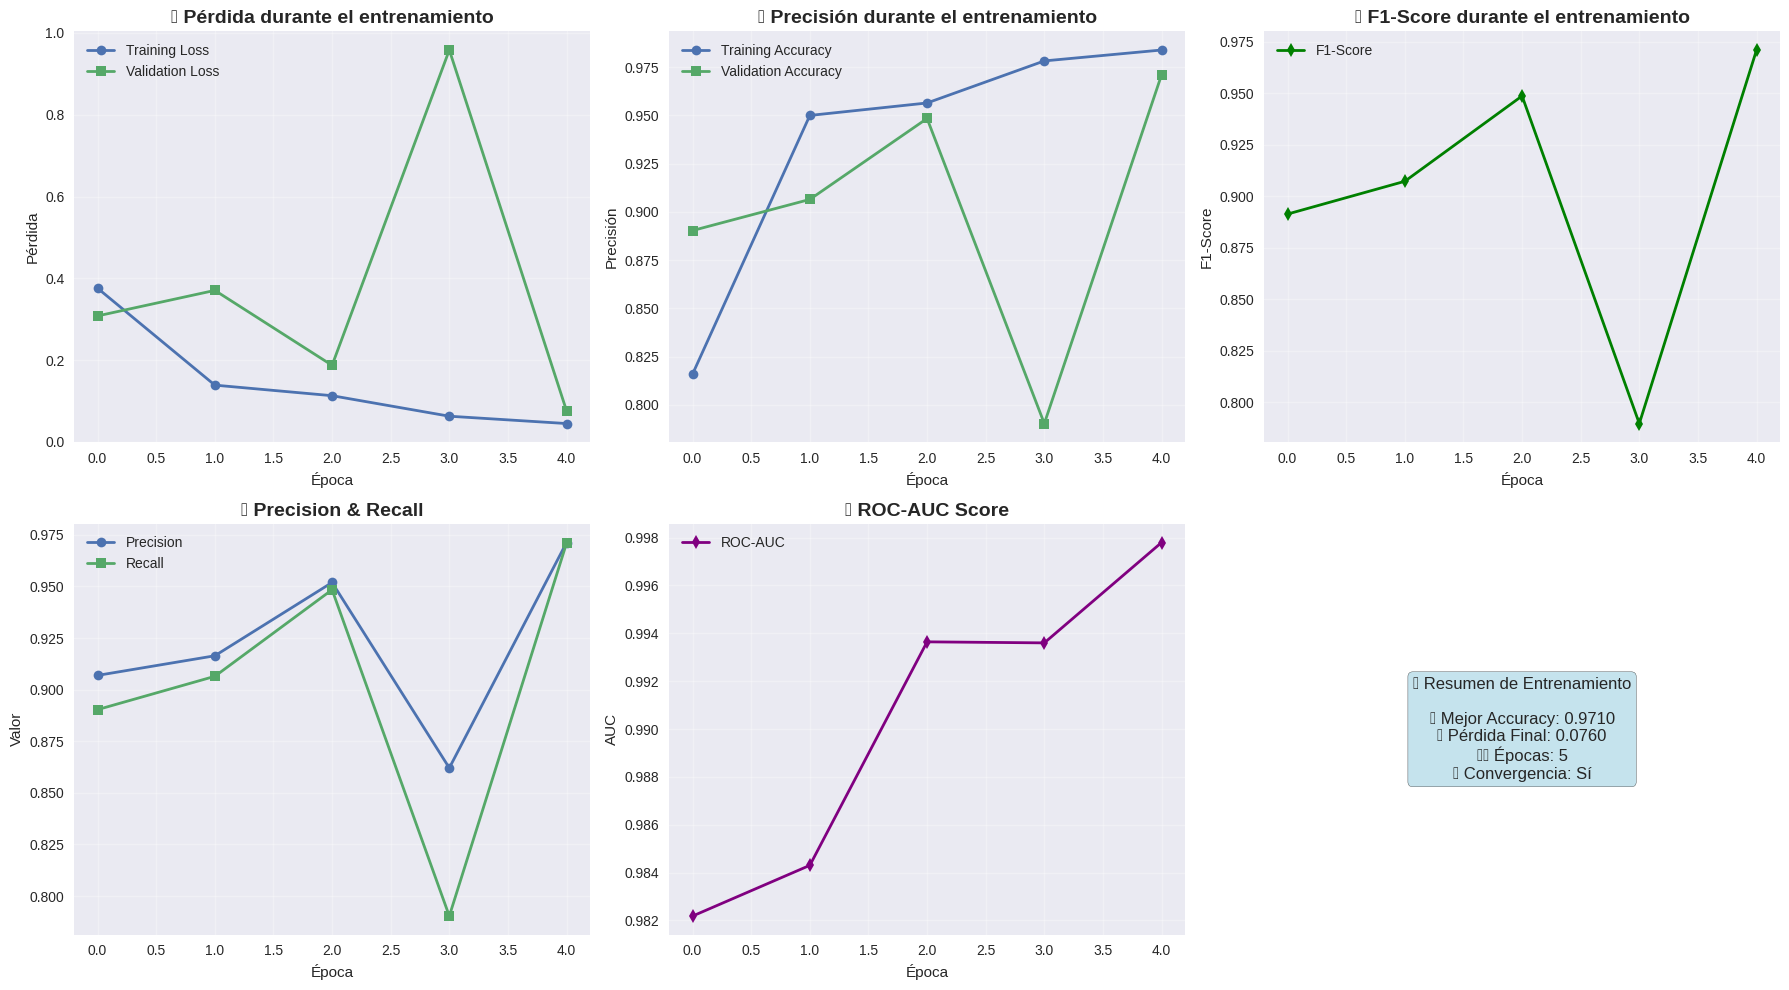

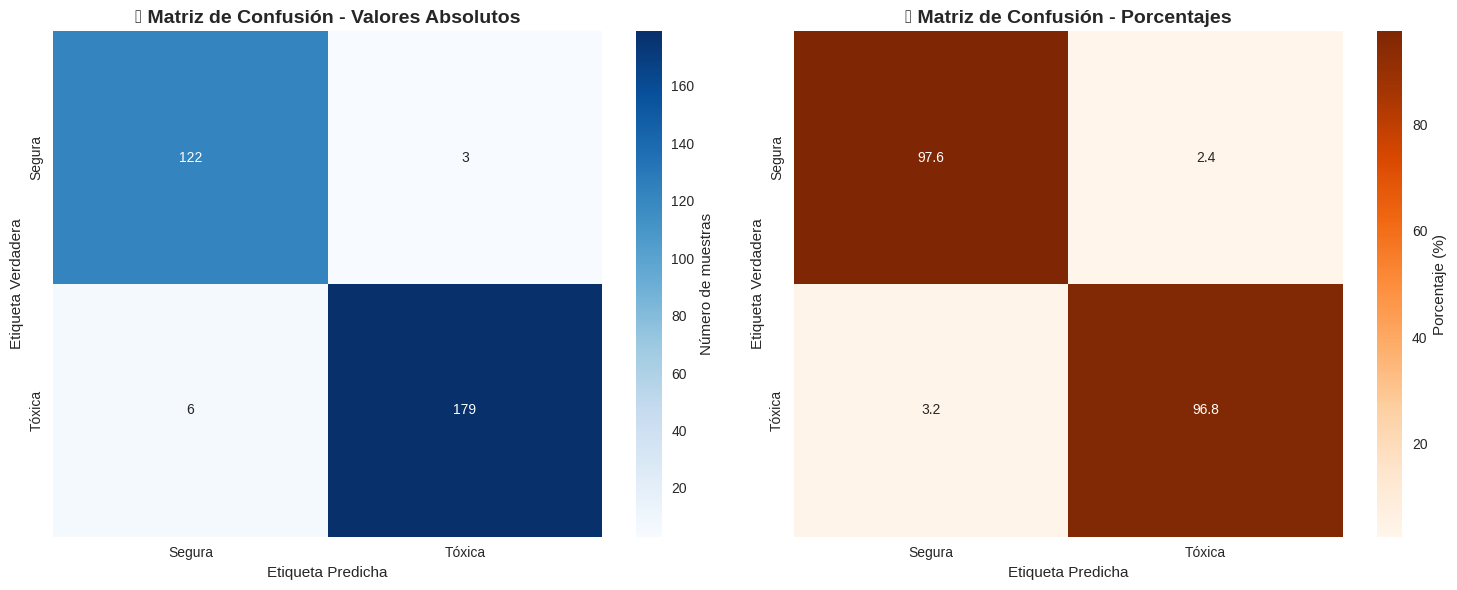


🔍 INTERPRETACIÓN DE LA MATRIZ DE CONFUSIÓN:
✅ Verdaderos Negativos (TN): 122 - Plantas seguras correctamente identificadas
❌ Falsos Positivos (FP): 3 - Plantas seguras marcadas como tóxicas
❌ Falsos Negativos (FN): 6 - Plantas tóxicas marcadas como seguras
✅ Verdaderos Positivos (TP): 179 - Plantas tóxicas correctamente identificadas

⚠️  ANÁLISIS DE ERRORES:
   El modelo tiende a ser PERMISIVO (marca plantas tóxicas como seguras)
   Esto es PELIGROSO para la seguridad de los gatos


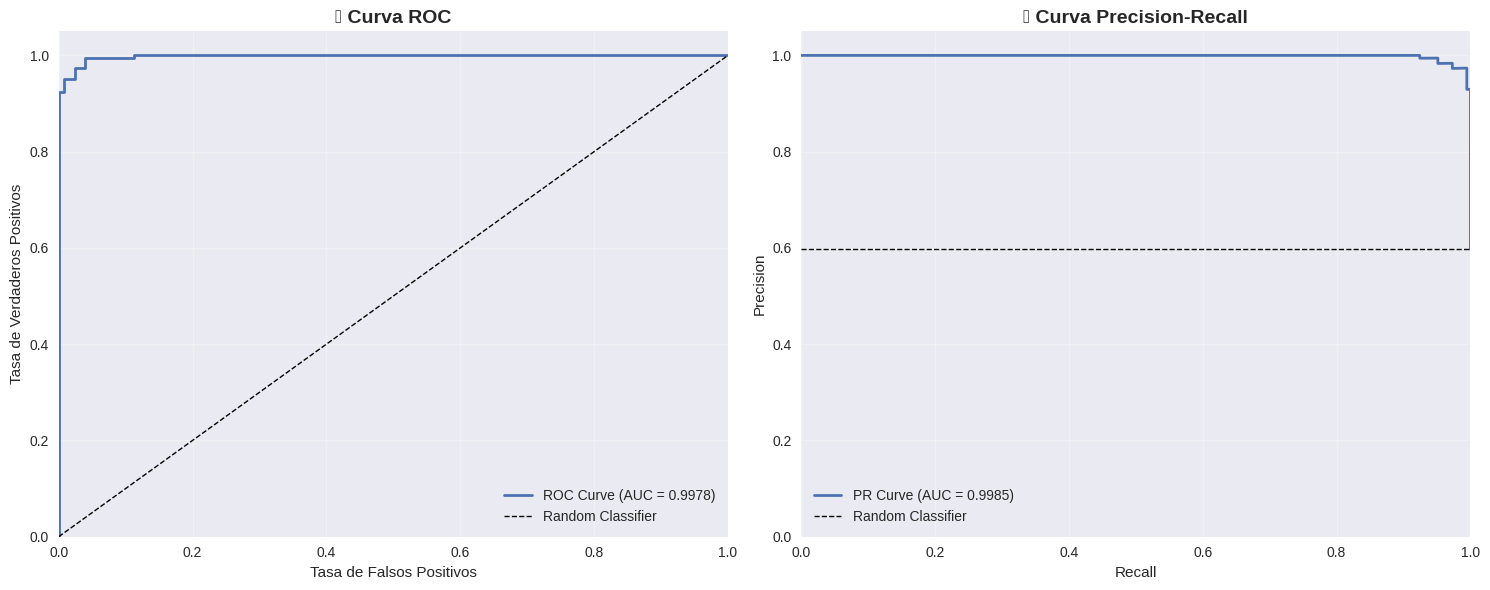


🔍 DEMOSTRANDO PREDICCIONES EN 3 EJEMPLOS:
🖼️  Ejemplo 1:
   🏷️  Etiqueta real: Segura
   🎯 Predicción: Segura
   📊 Prob. Tóxica: 0.000 (0.0%)
   📊 Prob. Segura: 1.000 (100.0%)
   💡 Recomendación: ✅ PROBABLE SEGURIDAD: Pero siempre supervisar
   ✅ Correcto

🖼️  Ejemplo 2:
   🏷️  Etiqueta real: Segura
   🎯 Predicción: Segura
   📊 Prob. Tóxica: 0.002 (0.2%)
   📊 Prob. Segura: 0.998 (99.8%)
   💡 Recomendación: ✅ PROBABLE SEGURIDAD: Pero siempre supervisar
   ✅ Correcto

🖼️  Ejemplo 3:
   🏷️  Etiqueta real: Segura
   🎯 Predicción: Segura
   📊 Prob. Tóxica: 0.000 (0.0%)
   📊 Prob. Segura: 1.000 (100.0%)
   💡 Recomendación: ✅ PROBABLE SEGURIDAD: Pero siempre supervisar
   ✅ Correcto



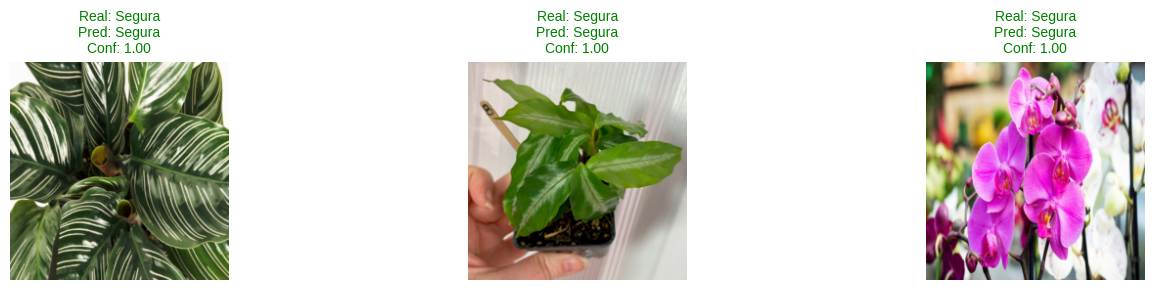


✅ ENTRENAMIENTO COMPLETADO!
🎯 F1-Score Final: 0.9710
📈 Accuracy Final: 0.0000
📁 Modelo guardado como: best_toxic_plant_model.pth


In [13]:
print("\n🌱 CLASIFICADOR DE PLANTAS TÓXICAS PARA GATOS")
print("=" * 70)
print("🎯 Objetivo: Proteger la salud felina mediante IA")
print("🤖 Modelo: Vision Transformer (ViT)")
print("📊 Dataset: House Plant Species")
print("⚡ Optimizado para Kaggle")
print("=" * 70)

try:
    print("\n🔎 Llamando a train_model con ruta:", output_path)
    model, metrics, val_loader = train_model(
        data_dir=output_path,
        num_epochs=5,
        batch_size=16,
        learning_rate=1e-4
    )

    if model is not None:
        demonstrate_prediction(model, val_loader, num_examples=3, umbral_tox=0.7)
        print("\n✅ ENTRENAMIENTO COMPLETADO!")
        print(f"🎯 F1-Score Final: {metrics['f1_score']:.4f}")
        print(f"📈 Accuracy Final: {metrics['accuracy']:.4f}")
        print("📁 Modelo guardado como: best_toxic_plant_model.pth")

except Exception as e:
    print(f"❌ Error durante el entrenamiento: {e}")